# RNN and LSTM

In [42]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
from torch.optim import lr_scheduler
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm

from dataset_utils import *

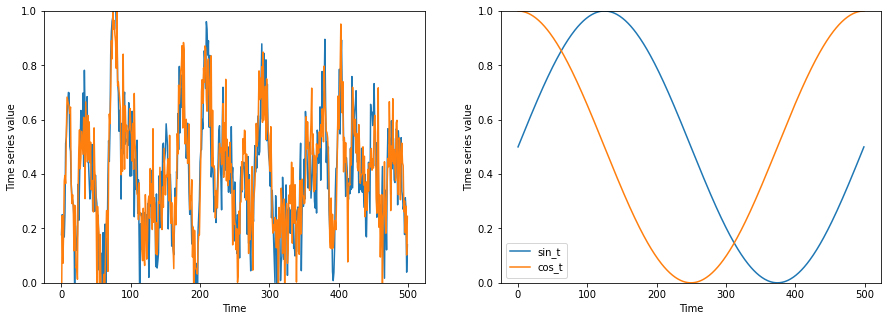

In [43]:
N_SAMPLES = 500
N_DIM = 2
LAGS = 60
FORECAST_HORIZON = 60

x = np.random.normal(0, 1, (N_SAMPLES, N_DIM))
x = gaussian_filter(x, 5)
x = (x - np.min(x))/(np.max(x)-np.min(x))
x = x + np.random.normal(0, 0.1, (N_SAMPLES, N_DIM))

# Sine and cosine features to track periodicity.
sin_t = np.sin(2*np.pi*np.linspace(0,N_SAMPLES, N_SAMPLES)/N_SAMPLES)
sin_t = (sin_t - np.min(sin_t))/(np.max(sin_t)-np.min(sin_t))
cos_t = np.cos(2*np.pi*np.linspace(0,N_SAMPLES, N_SAMPLES)/N_SAMPLES)
cos_t = (cos_t - np.min(cos_t))/(np.max(cos_t)-np.min(cos_t))

aux_series = np.concatenate([np.expand_dims(sin_t, 1), np.expand_dims(cos_t, 1)], axis=1)

if len(np.shape(x)) < 2:
    x = np.expand_dims(x, 1)

fig, axs = plt.subplots(1, 2, figsize=(15,5))

axs[0].plot(x)
axs[0].set_ylim([0,1])
axs[0].set_xlabel("Time")
axs[0].set_ylabel("Time series value")

axs[1].plot(sin_t, label="sin_t")
axs[1].plot(cos_t, label="cos_t")
axs[1].set_ylim([0,1])
axs[1].set_xlabel("Time")
axs[1].set_ylabel("Time series value")
plt.legend()

plt.show()

In [44]:
train_dataset = TimeSeriesDataset(x, FORECAST_HORIZON, LAGS, aux_series)
trainLoader = DataLoader(train_dataset)
validLoader = DataLoader(train_dataset)

sample_idx, sample_x, sample_y = next(iter(train_dataset))

In [45]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size)).cuda()
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size)).cuda()
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        
        return out

In [50]:
epochs = 20
lr = 0.01
batch_size = 16

input_size = sample_x.shape[1]
seq_length = LAGS
hidden_size = 20
num_layers = 1

num_classes = (FORECAST_HORIZON, 2)

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, seq_length)

TypeError: new() received an invalid combination of arguments - got (tuple, int), but expected one of:
 * (*, torch.device device)
      didn't match because some of the arguments have invalid types: ([31;1mtuple[0m, [31;1mint[0m)
 * (torch.Storage storage)
 * (Tensor other)
 * (tuple of ints size, *, torch.device device)
 * (object data, *, torch.device device)


In [47]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using {}".format(device))

Using cuda:0


In [48]:
def train(net, device):
    '''
    main function to run the training
    '''

    if torch.cuda.device_count() > 1:
        net = nn.DataParallel(net)
    net.to(device)

    lossfunction = nn.MSELoss().cuda()
    optimizer = optim.Adam(net.parameters(), lr=lr)
    pla_lr_scheduler = lr_scheduler.ReduceLROnPlateau(optimizer,
                                                      factor=0.5,
                                                      patience=4,
                                                      verbose=True)

    # to track the training loss as the model trains
    train_losses = []
    # to track the validation loss as the model trains
    valid_losses = []
    # to track the average training loss per epoch as the model trains
    avg_train_losses = []
    # to track the average validation loss per epoch as the model trains
    avg_valid_losses = []
    # mini_val_loss = np.inf
    for epoch in range(0, epochs + 1):
        ###################
        # train the model #
        ###################
        t = tqdm(trainLoader, leave=False, total=len(trainLoader))
        for i, (idx, inputVar, targetVar) in enumerate(t):
            inputs = inputVar.to(device).float()  # B,S,C,H,W
            label = targetVar.to(device).float()  # B,S,C,H,W
            optimizer.zero_grad()
            net.train()
            pred = net(inputs)  # B,S,C,H,W
            loss = lossfunction(pred.unsqueeze(2), label)
            loss_aver = loss.item() / batch_size
            train_losses.append(loss_aver)
            loss.backward()
            torch.nn.utils.clip_grad_value_(net.parameters(), clip_value=10.0)
            optimizer.step()
            t.set_postfix({
                'trainloss': '{:.6f}'.format(loss_aver),
                'epoch': '{:02d}'.format(epoch)
            })
        ######################
        # validate the model #
        ######################
        with torch.no_grad():
            net.eval()
            t = tqdm(validLoader, leave=False, total=len(validLoader))
            for i, (idx, inputVar, targetVar) in enumerate(t):
                if i == 3000:
                    break
                inputs = inputVar.to(device).float()
                label = targetVar.to(device).float()
                pred = net(inputs)
                loss = lossfunction(pred.unsqueeze(2), label)
                loss_aver = loss.item() / batch_size
                # record validation loss
                valid_losses.append(loss_aver)
                #print ("validloss: {:.6f},  epoch : {:02d}".format(loss_aver,epoch),end = '\r', flush=True)
                t.set_postfix({
                    'validloss': '{:.6f}'.format(loss_aver),
                    'epoch': '{:02d}'.format(epoch)
                })

        torch.cuda.empty_cache()
        # print training/validation statistics
        # calculate average loss over an epoch
        train_loss = np.average(train_losses)
        valid_loss = np.average(valid_losses)
        avg_train_losses.append(train_loss)
        avg_valid_losses.append(valid_loss)

        epoch_len = len(str(epochs))

        print_msg = (f'[{epoch:>{epoch_len}}/{epochs:>{epoch_len}}] ' +
                     f'train_loss: {train_loss:.6f} ' +
                     f'valid_loss: {valid_loss:.6f}')

        print(print_msg)
        # clear lists to track next epoch
        train_losses = []
        valid_losses = []
        pla_lr_scheduler.step(valid_loss)  # lr_scheduler
        model_dict = {
            'epoch': epoch,
            'state_dict': net.state_dict(),
            'optimizer': optimizer.state_dict()
        }

In [49]:
train(lstm.to(device), device)

c:\users\greg\desktop\standard_env\lib\site-packages\torch\nn\modules\loss.py:432: UserWarning: Using a target size (torch.Size([1, 60, 2])) that is different to the input size (torch.Size([1, 60, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[ 0/20] train_loss: 0.003352 valid_loss: 0.002708


KeyboardInterrupt: 